# **Project 1**

@To do 
* write a short description for the project
* define the goals
* brief explanation about regression and the libraries I'll use
* Add the scope of the project (feature engineering won't be applied).

### **Regression**

*Regression is where models predict a number. (Microsoft)*

Supervised machine learning techniques involve training a model to operate on a set of features and predict a label using a dataset that includes some already-known label values. The training process fits the features to the known labels to define a general function that can be applied to new features for which the labels are unknown, and predict them. We can think of this function like this, in which y represents the label we want to predict and x represents the features the model uses to predict it.

In [1]:
# Setting up the environment

import numpy as np
import pandas as pd
from experiment import PreprocessData
from experiment import CustomModel
from plotter import DataPlotter

import matplotlib.pyplot as plt



In [2]:
data = np.load('data/proyecto_training_data.npy')

In [3]:
df = pd.DataFrame(data, columns=['SalePrice','OverallQual','FloorSquareFeet','TotalRooms','YearBuilt','LotFrontage'])

df.head()

,SalePrice,OverallQual,FloorSquareFeet,TotalRooms,YearBuilt,LotFrontage
0,208500.0,7.0,856.0,8.0,2003.0,65.0
1,181500.0,6.0,1262.0,6.0,1976.0,80.0
2,223500.0,7.0,920.0,6.0,2001.0,68.0
3,140000.0,7.0,961.0,7.0,1915.0,60.0
4,250000.0,8.0,1145.0,9.0,2000.0,84.0


The data consists of the following columns:

* **SalePrice**: the property's sale price in dollars. This is the target variable that you're trying to predict.
* **OverallQual**: Overall material and finish quality, rates the overall material and finish of the house.
* **FloorSquareFeet**: First Floor square feet.
* **TotalRooms**: Total rooms above grade (does not include bathrooms)
* **YearBuilt**: Original construction date.
* **LotFrontage**: Linear feet of street connected to property.

In this dataset, **SalePrice** represents the label (the y value) our model must be trained to predict. The other columns are potential features (x values). 

As we can see, some columns are of float type, when based on the information they contain we can infer that they should correspond to integers, in this case we make the adjustment to set the correct types.

In [6]:
df[['TotalRooms','YearBuilt']] = df[['TotalRooms','YearBuilt']].astype(int)

df.head()

,SalePrice,OverallQual,FloorSquareFeet,TotalRooms,YearBuilt,LotFrontage
0,208500.0,7.0,856.0,8,2003,65.0
1,181500.0,6.0,1262.0,6,1976,80.0
2,223500.0,7.0,920.0,6,2001,68.0
3,140000.0,7.0,961.0,7,1915,60.0
4,250000.0,8.0,1145.0,9,2000,84.0


### **Handling missing values**

Given that we are exploring the data, it's importat to review the missing values in the data. In order to do that, we can use the methods ```isnull()``` and ```sum()``` from pandas:

In [7]:
df.isnull().sum()

SalePrice            0
OverallQual          0
FloorSquareFeet      0
TotalRooms           0
YearBuilt            0
LotFrontage        259
dtype: int64

The output shows that the column **LotFrontage** has 259 missing values. Although there are different methods to handle these cases, we will use the approach of deleting the entire row for simplicity in this project.

In [8]:
df = df.dropna()

### **Exploring the data**

Now that we've handled the missing values, we can explore the data. To do so, we use the ```describe()``` method to check the **mean**, **min** and **max** values.

In [9]:
df.describe()

,SalePrice,OverallQual,FloorSquareFeet,TotalRooms,YearBuilt,LotFrontage
count,1201.000000,1201.000000,1201.000000,1201.000000,1201.000000,1201.000000
mean,180770.480433,6.122398,1158.437968,6.535387,1970.580350,70.049958
std,83389.519866,1.419216,386.257235,1.629608,31.750335,24.284752
min,34900.000000,1.000000,334.000000,2.000000,1872.000000,21.000000
25%,127500.000000,5.000000,876.000000,5.000000,1950.000000,59.000000
50%,159500.000000,6.000000,1082.000000,6.000000,1972.000000,69.000000
75%,213500.000000,7.000000,1383.000000,7.000000,2003.000000,80.000000
max,755000.000000,10.000000,4692.000000,14.000000,2010.000000,313.000000


At first glance, we can observe that the mean of the sale prices is around $181000, while the standard deviation is around $83000, indicating a large variation in prices. To have a clearer idea of the price distribution, we can visualize the data using histograms and box plots as follows:

/var/folders/bw/5rhpjqf916g25y1gn5gw3nzr0000gn/T/ipykernel_9984/2049416241.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


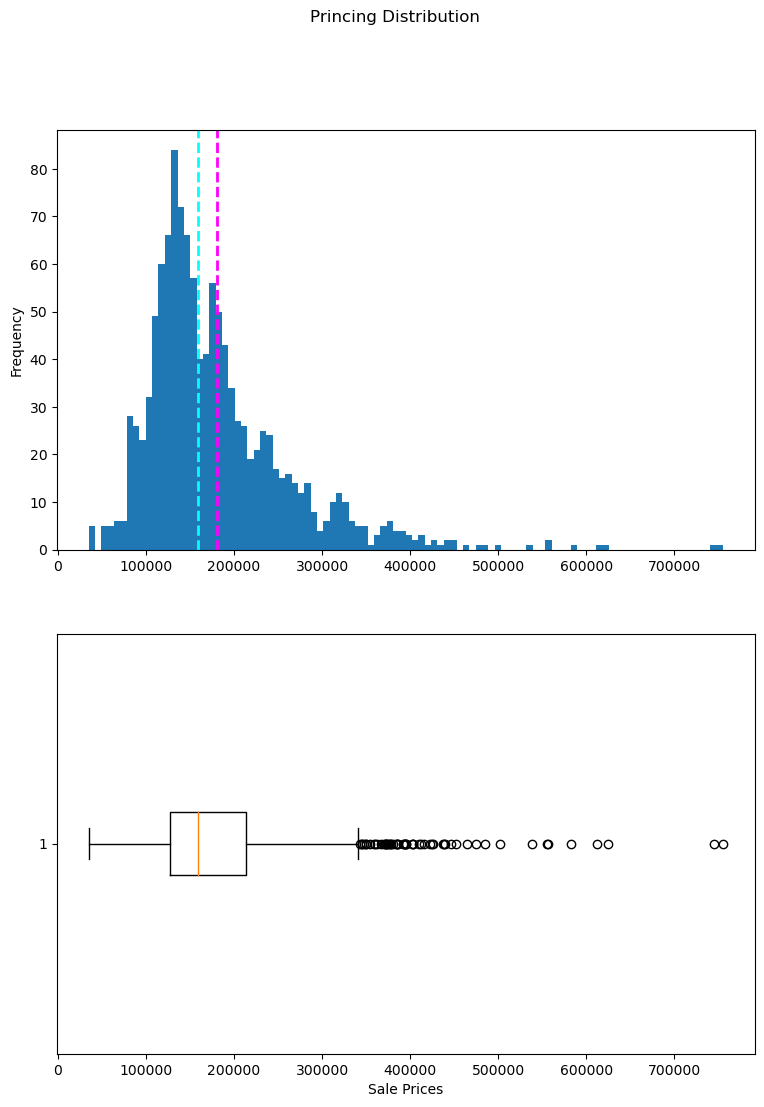

In [10]:
import matplotlib.pyplot as plt

# This ensures plots are displayed inline in the notebook
%matplotlib inline

# Get the label column
label = df['SalePrice']

# Create a figure for 2 subplots (2 rows, 1 column)
fig, ax = plt.subplots(2, 1, figsize = (9,12))

# Plot the histogram   
ax[0].hist(label, bins=100)
ax[0].set_ylabel('Frequency')

# Add lines for the mean, median, and mode
ax[0].axvline(label.mean(), color='magenta', linestyle='dashed', linewidth=2)
ax[0].axvline(label.median(), color='cyan', linestyle='dashed', linewidth=2)

# Plot the boxplot   
ax[1].boxplot(label, vert=False)
ax[1].set_xlabel('Sale Prices')

# Add a title to the Figure
fig.suptitle('Princing Distribution')

# Show the figure
fig.show()

From these plots, we can observe that the majority of the data falls within the price range of $30,000 to $340,000, with the mean close to the middle of this range. Prices above $340,000 appear to be unusual, indicating that they are **outliers**. 

We will perform the same kind of exploration for the for the numeric features.

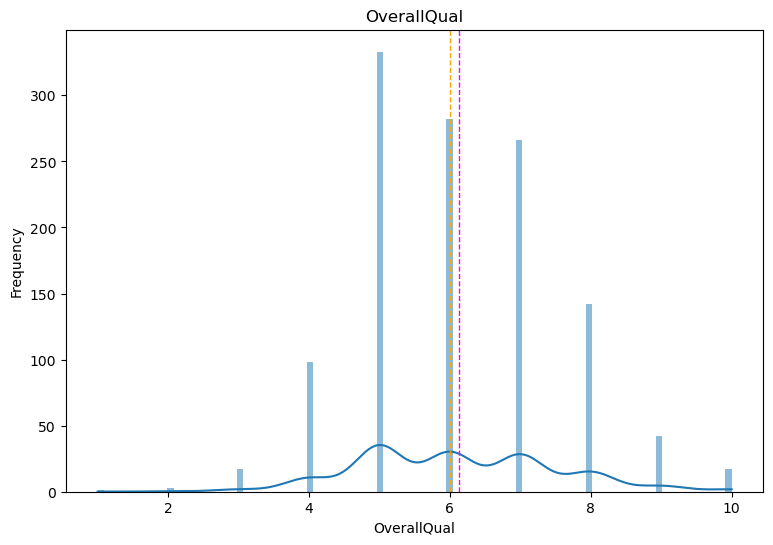

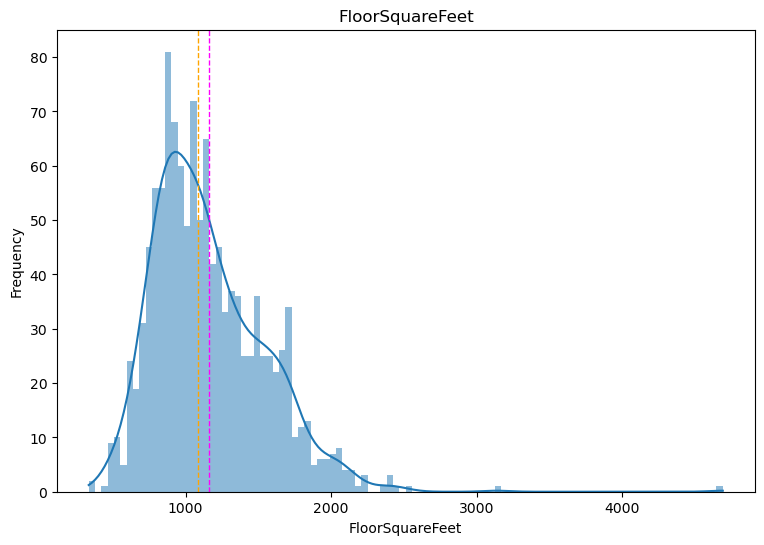

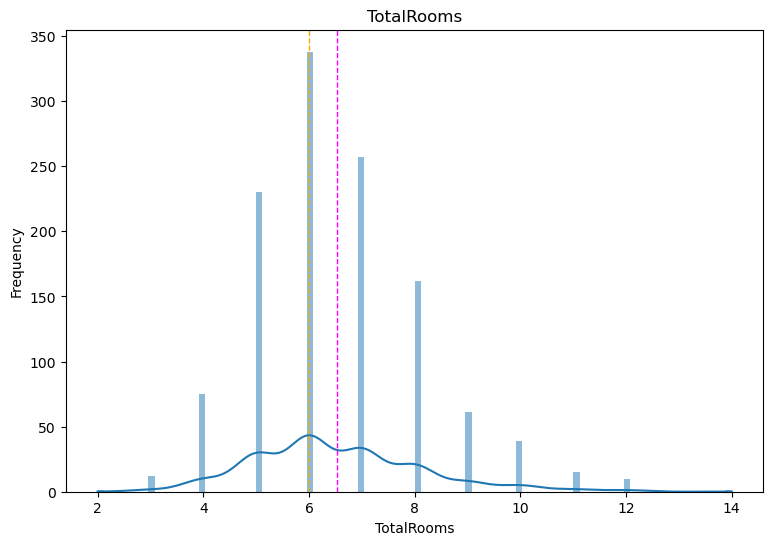

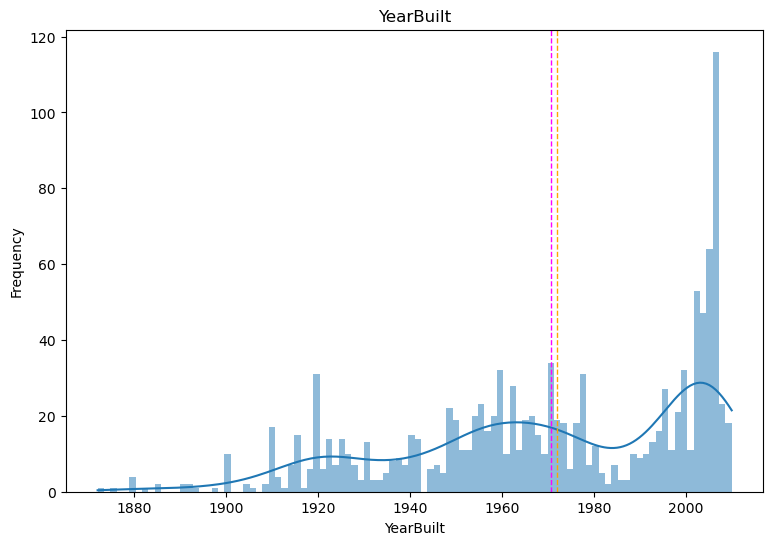

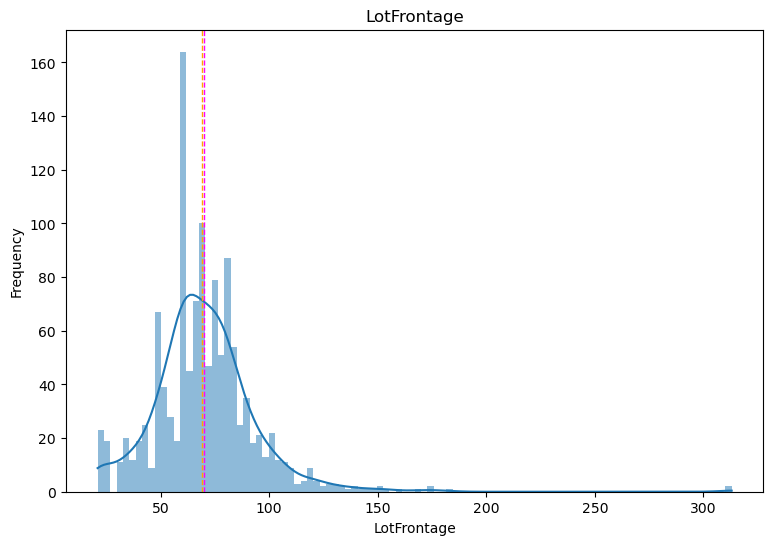

In [19]:
import seaborn as sns

features = ['OverallQual','FloorSquareFeet','TotalRooms','YearBuilt','LotFrontage']

for col in features:
    fig, ax = plt.subplots(figsize=(9, 6))
    sns.histplot(data=df[col], ax=ax, kde=True, bins=100, edgecolor='none')
    ax.axvline(df[col].mean(), color='magenta', linestyle='dashed', linewidth=1)
    ax.axvline(df[col].median(), color='orange', linestyle='dashed', linewidth=1)
    ax.set_ylabel('Frequency')
    ax.set_title(col)
plt.show()

As we can see, features seems to be more normally distributed than the label.

Now that we know more about the data in columns, we can analyze the relationship between the features and the label values. We can also calculate the correlation statistic to quantify the apparent relationship.

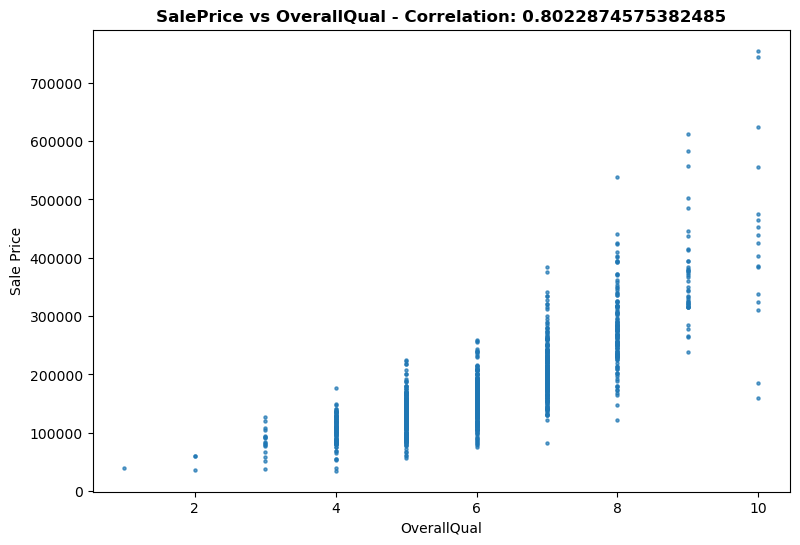

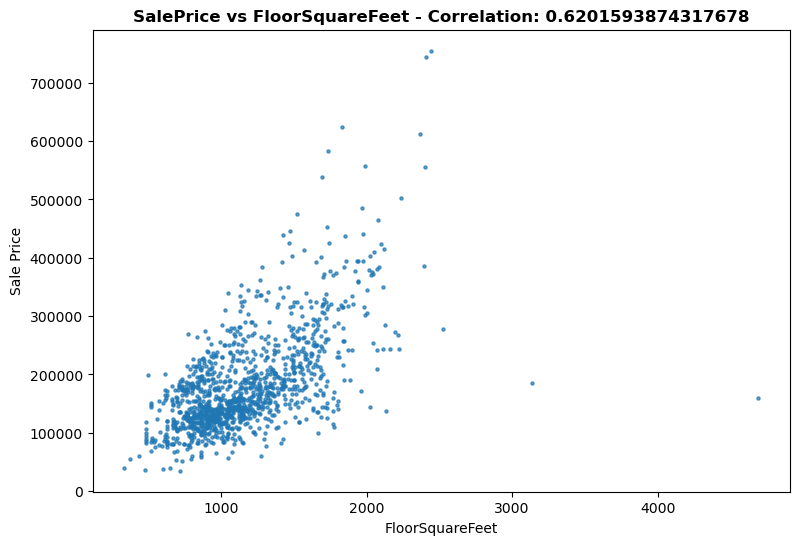

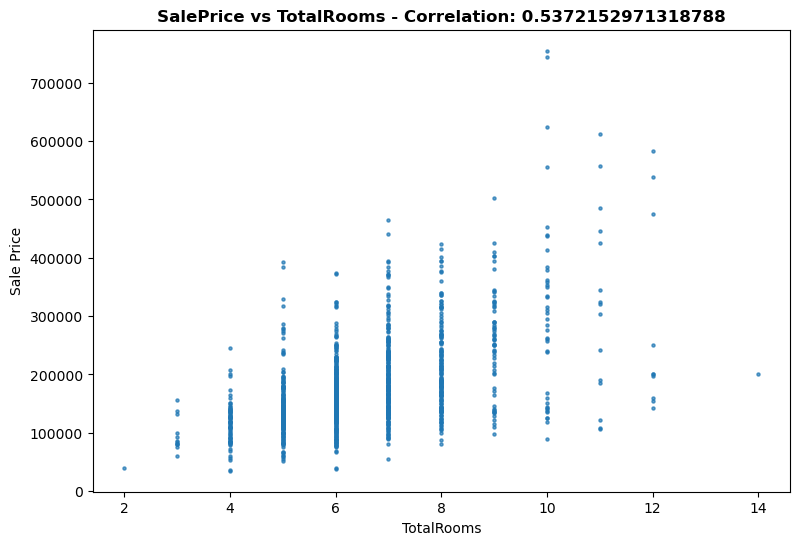

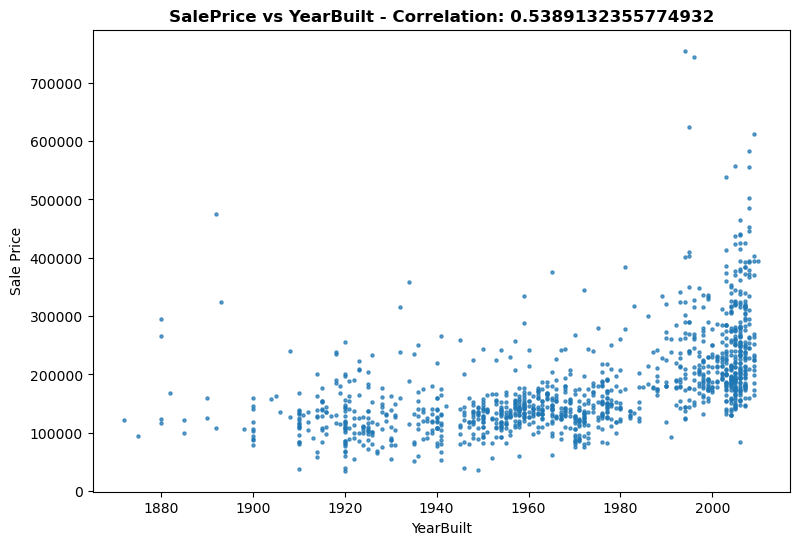

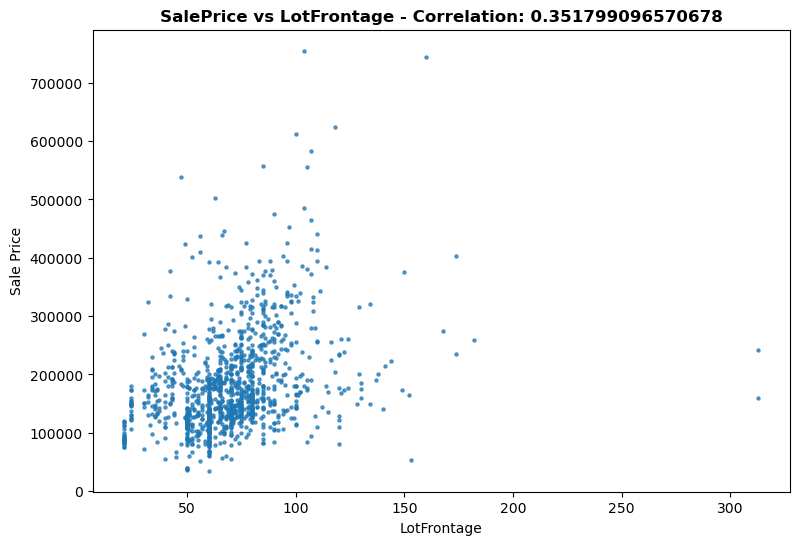

In [24]:
for col in features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = df[col]
    label = df['SalePrice']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label, s=5, alpha=0.7)
    plt.xlabel(col)
    plt.ylabel('Sale Price')
    ax.set_title('SalePrice vs ' + col + ' - Correlation: ' + str(correlation), fontweight='bold')
plt.show()

Although the results may not seem very conclusive, a trend can be observed where the **OverallQual** rate coincides with high house prices. The same behavior is observed with the **FloorSquareFeet** of the property. In both cases, a correlation above 0.6 is observed, which indicates a positive correlation.

### **Train the regression model**

Now that we've explored the data, it's time to use it to train a regression model that uses the features we've identified as potentially predictive to predict the rentals label. The first thing we need to do is to separate the features we want to use to train the model from the label we want it to predict.

According to the results obtained from the data exploration, we will first review the model for **OverallQual** and then for **FloorSquareFeet**.

#### **Feature: OverallQual**

In [21]:
# Assing values to the label y - SalePrice
y = data[:,0]

# Assign values to the feature X - OverallQual
X_f1 = data[:,1]

# Split the data into training and testing sets
preprocess = PreprocessData()
X_train_f1, y_train, X_test, y_test = preprocess.split_data(X_f1, y, 0.8)

Now we're ready to train a model by fitting an univariate regression algorithm to the training data. We'll use a linear regression algorithm in order to find a linear relationship between the X values and the y label. The resulting model is a dictionary that conceptually defines a line where every possible X and y value combination intersect.

In [22]:
# Create an instance of the CustomModel class and train the model
model = CustomModel()
model_dict_f1, errors_f1 = model.train(X_train_f1, y_train, epochs=30, print_error_interval=10, alpha=0.01)

Epoch 0, error: 39168578545.59951
Epoch 10, error: 2810756638.5616965
Epoch 20, error: 2802211228.533164


**Model evaluation**

As a result of the training function, we have obtained the error through the **Mean Squared Error (MSE)** function with the values calculated for the gradient descent at each iteration. These error values are shown in the following graph:

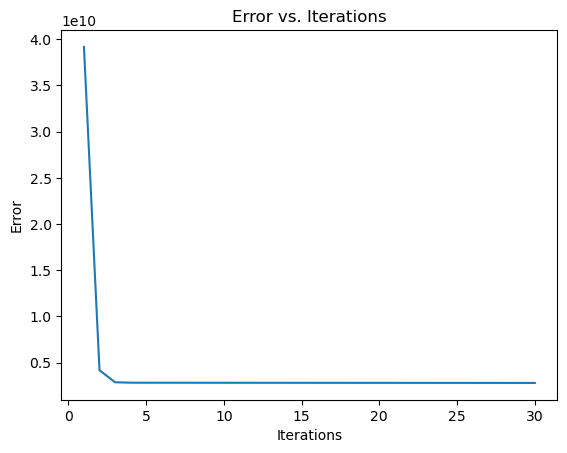

In [23]:
DataPlotter.plot_error(errors_f1)

As can be seen from the graph, as the weights were updated at each iteration, the calculation of the gradient descent improved the model, obtaining error measures that approach zero. **The lower the value, the better the model prediction will be.**

**Model evolution**

In the following graph we can observe how the predictability of the model evolves in each iteration.

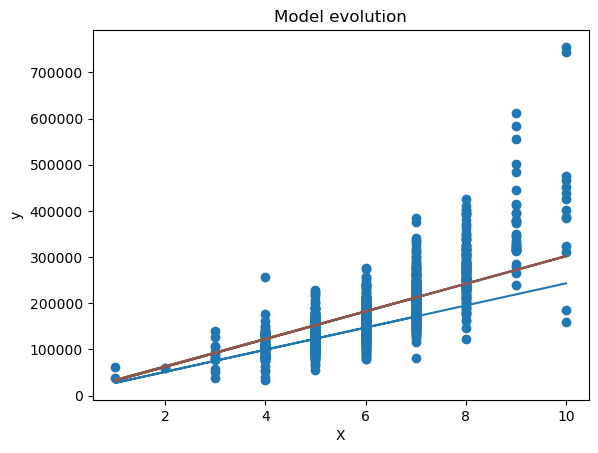

In [26]:
DataPlotter.plot_evolution(model_dict_f1,n=5,X=X_train_f1,y=y_train)

#### **Feature: FloorSquareFeet**

In [28]:
# Assing values to the label y - SalePrice
y = data[:,0]

# Assign values to the feature X - FloorSquareFeet
X_f2 = data[:,2]

# Split the data into training and testing sets
preprocess = PreprocessData()
X_train_f2, y_train, X_test, y_test = preprocess.split_data(X_f2, y, 0.8)

Training the model:

In [33]:
# Training the model with the data
model_dict_f2, errors_f2 = model.train(X_train_f2, y_train, epochs=30, print_error_interval=10, alpha=0.01)

Epoch 0, error: 38942332495.09156
Epoch 10, error: 1.7296929024064686e+100
Epoch 20, error: 8.608188636554947e+189


**Model evaluation**

As the evaluation for the OverallQual feature, we can observe how the obtained MSE changes with the values calculated for the gradient descent at each iteration. The errors and model prediction are shown in the following graphs:

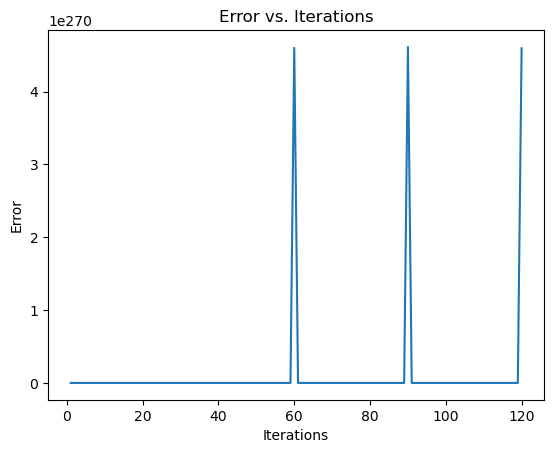

In [35]:
DataPlotter.plot_error(errors_f2)

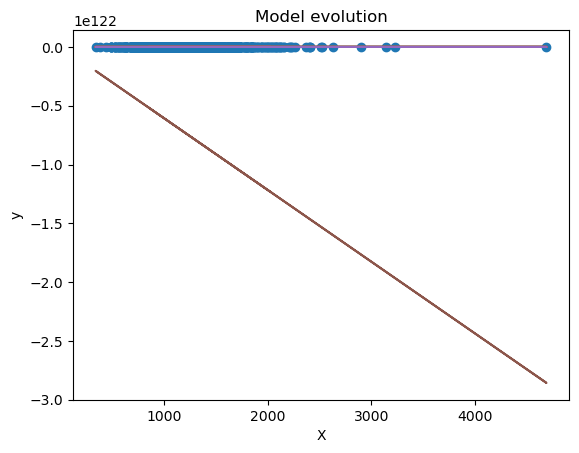

In [36]:
DataPlotter.plot_evolution(model_dict_f2,n=5,X=X_train_f2,y=y_train)